In [1]:
#import models
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential, utils, Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
# import dataset
import pathlib
data_dir = "C:\\Users\\24793\\Downloads\\Defect_dataset\\capsule.tar\\capsule\\dataset_defect"
data_dir = pathlib.Path(data_dir)

batch_size = 16
img_width  = 224
img_height = 224

train_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="training",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 437 files belonging to 2 classes.
Using 350 files for training.
Found 437 files belonging to 2 classes.
Using 87 files for validation.
['defect', 'good']


In [ ]:
'''
model = Sequential()
model.add(ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)))

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())

model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2))
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.compile(optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()
'''

In [3]:
# Load ResNet50 without top layers
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)

x = layers.Dense(1024, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)

output_layer = layers.Dense(2, activation="softmax")(x)  # 2 classes

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [4]:
import datetime, os
from sklearn.utils import class_weight

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

class_weight_dict = {}
class_weight_dict[0] = 1.5
class_weight_dict[1] = 0.75

epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=False,
  #class_weight=class_weight_dict,
  callbacks=[tensorboard_callback]
)

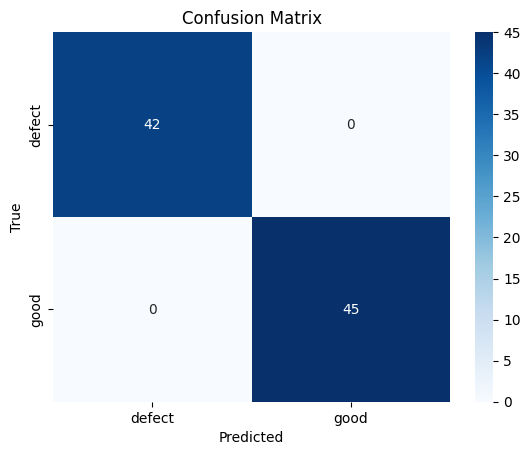

              precision    recall  f1-score   support

      defect       1.00      1.00      1.00        42
        good       1.00      1.00      1.00        45

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



In [5]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

target_names = val_ds.class_names 

y_true = []
y_pred = []

for images, labels in val_ds:
    y_true = y_true + labels.numpy().tolist() 

    temp_pred = model.predict(images, verbose=0)
    temp_pred = np.argmax(temp_pred, axis = 1)
    y_pred = y_pred + temp_pred.tolist()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['defect', 'good'], yticklabels=['defect', 'good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=target_names))

In [6]:
def compute_gradcam(img_path, model, layer_name, class_index=None):
    """Computes Grad-CAM heatmap for a given image."""
    
    # Load & preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalize

    # Define Grad-CAM model
    grad_model = Model(inputs=model.input, 
                       outputs=[model.get_layer(layer_name).output, model.output])

    # Get feature maps & predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = np.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute Grad-CAM heatmap
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize and colorize heatmap
    heatmap = cv2.resize(heatmap, (img.size[1], img.size[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay on original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    return superimposed_img, heatmap


1/1 [==============================] - 0s 57ms/step
class :  [1]


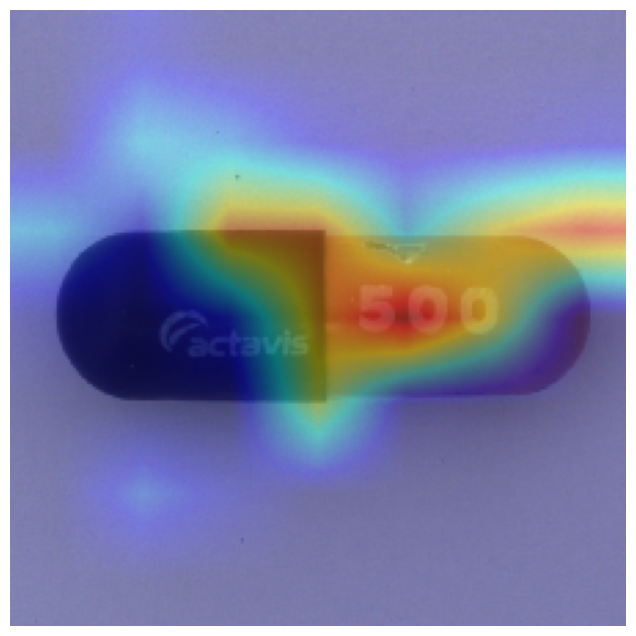

((-0.5, 223.5, 223.5, -0.5), None)

In [10]:
# ================== Run Grad-CAM on an Image ==================

img_path = "crack_019.png"  # Provide an image path
conv_layer = "conv5_block3_out"  # Last convolutional layer in ResNet50

img_ = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img_)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
img_array = preprocess_input(img_array)  # Normalize

print("class : ", np.argmax(model.predict(img_array), axis = 1))

gradcam_output, heatmap = compute_gradcam(img_path, model, conv_layer)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(gradcam_output, cv2.COLOR_BGR2RGB))
plt.axis("off"), plt.show()

In [2]:

%pip install keras_cv

  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
   ---------------------------------------- 0.0/650.7 kB ? eta -:--:--
   -------------------------------- ------- 524.3/650.7 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 650.7/650.7 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/950.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/950.8 k

In [9]:
import torch
import numpy as np
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel

# Load Pretrained ViT Model
#model = timm.create_model("vit-base-patch16-224", pretrained=True)
#model = timm.create_model("vit_base_patch16_224", pretrained=True, cache_dir="C:\\Abhishek Data\\VSCode_Workspace\\Python\\Defect_detection")
hf_model = ViTModel.from_pretrained("C:\\Abhishek Data\\VSCode_Workspace\\Python\\Defect_detection\\vit-base-patch16-224")
state_dict = hf_model.state_dict()

model = timm.create_model("vit-base-patch16-224", pretrained=False)
model.load_state_dict(state_dict, strict=False)
model.eval()  # Set to evaluation mode

# Load & Preprocess Image
def preprocess_image(image_path, img_size=224):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

# Extract Attention Maps from ViT
def get_attention_map(model, img_tensor):
    with torch.no_grad():
        outputs = model.forward_features(img_tensor)  # Extract Transformer features
    attn_map = outputs.mean(dim=1)  # Average across attention heads
    attn_map = attn_map.squeeze().cpu().numpy()  # Convert to NumPy
    return attn_map

# Overlay Attention Map on Image
def overlay_attention_map(image, attention_map):
    attention_map = cv2.resize(attention_map, (image.size[0], image.size[1]))  # Resize
    attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))  # Normalize
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)  # Apply color map
    superimposed_img = cv2.addWeighted(np.array(image), 0.6, heatmap, 0.4, 0)  # Blend images
    return superimposed_img

# Run the Visualization
image_path = "crack_019.png"  # Replace with your image
original_img, img_tensor = preprocess_image(image_path)
attention_map = get_attention_map(model, img_tensor)

# Display the Attention Map
attention_overlay = overlay_attention_map(original_img, attention_map)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(attention_overlay)
plt.title("Attention Map Overlay")
plt.show()


Some weights of ViTModel were not initialized from the model checkpoint at C:\Abhishek Data\VSCode_Workspace\Python\Defect_detection\vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Unknown model (vit-base-patch16-224)

In [15]:
import torch
import cv2
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
import requests
import matplotlib.pyplot as plt

# Load model
model_name = 'vit-base-patch16-224'
model = ViTModel.from_pretrained(model_name, output_attentions=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

image_path = "C:\\Abhishek Data\\VSCode_Workspace\\Python\\Defect_detection\\crack_019.png"  # Change this to your image path
image_bgr = cv2.imread("crack_019.png")

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Convert to PIL Image because feature_extractor expects PIL Image
image = Image.fromarray(image_rgb)
inputs = feature_extractor(images=image, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions  # (layers, batch_size, heads, tokens, tokens)

# Visualize attention
def show_attention_map(attention, layer=5, head=3):
    attention_map = attention[layer][0, head]  # Take batch index 0
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(attention_map.cpu(), cmap='viridis')
    ax.set_title(f'Layer {layer+1} Head {head+1} Attention Map')
    plt.axis('off')
    plt.show()

show_attention_map(attentions, layer=5, head=3)

Some weights of ViTModel were not initialized from the model checkpoint at vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: 'NoneType' object is not subscriptable